In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from LPSolver import LPSolver
from QPSolver import QPSolver
from SOCPSolver import SOCPSolver
from LassoSolver import LassoSolver
import cvxpy as cp

In [36]:
rng = np.random.default_rng(10)

### Generate a feasible problem instance

In [132]:
m = 80  # number of equality constraints -- keep lower than number of variables to ensure there are multiple solutions to the problem
n = 100  # number of variables

A = rng.normal(size = (m,n))

random_row_index = np.random.choice(m)

# Set all entries in the selected row to their absolute values
A[random_row_index, :] = np.abs(A[random_row_index, :])

b = A@np.abs(rng.normal(size = (n,)))
c = rng.normal(size = (n,))

### Create a LPSolver object

Can specify use_gpu = True if you want to run with a GPU. GPU solver typically starts to surpass performance of CPU solver ~500 variables (depending on system)

Also able to make multiple instances of this object to compare different hyperparameters

In [107]:
""""Initialize LP problem of form:
        Minimize c^T x
        Subject to Ax == b
                   Cx <= d
                   lower_bound <= x <= upper_bound

Can leave A, b, C, d, and c as None or specify matrices/vectors to constrain the problem
"""

ls= LPSolver(c=c,
        A=A,
        b=b,
        C=None,
        d=None,
        use_gpu=False,
        upper_bound=3,
        lower_bound=0,
        suppress_print=False)


Testing CVXPY


#### Compare LPSolver solution to the CVXPY solution
Check the ls.value parameter if you want to extract the value of the solution, use ls.xstar to get the minimizer

In [108]:
ls.solve(track_loss=True) - ls.cvxpy_val

proceeding to solve method
Objective value is now -9.749543445655403
Objective value is now -12.482865931366325
Objective value is now -18.00600746798963
Objective value is now -18.78455337477994
Objective value is now -18.84623509924209
Objective value is now -18.850028166628647
Objective value is now -18.85026822813439
Objective value is now -18.850285355927088
Objective value is now -18.850287735609886
Objective value is now -18.849852362951353


-1.9963867394778845e-06

In [111]:
# confirm that constraints are satisfied to a reasonable level
np.linalg.norm(A@ls.x - b)

0.0003636517387264193

<Axes: title={'center': 'Convergence of LPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

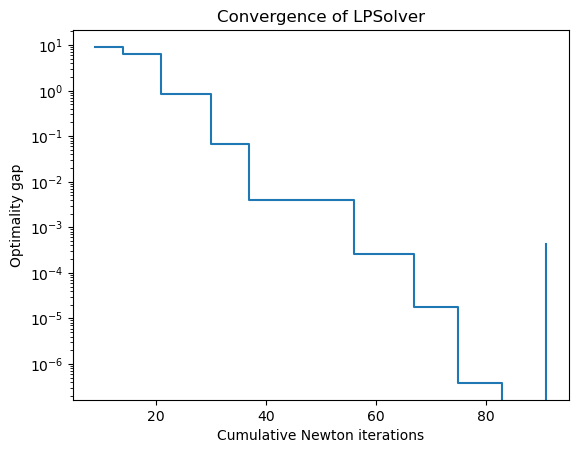

In [112]:
ls.plot() # the algorithm quit once the objective value stopped decreasing (which may happen in equality constrained problems)

### Benchmark LPSolver times vs. CVXPY
Can also generate multiple instances of LP to benchmark times of different hyperparameters

In [ ]:
%%timeit
x = cp.Variable(len(c))
obj = cp.Minimize(c.T@x)
constr = [A@x == b,
        x <= 0]
prob = cp.Problem(obj, constr)
prob.solve(solver='CLARABEL')


4.71 s ± 40.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit ls.solve(resolve=True)

2.03 s ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit ls_gpu.solve(resolve=True)

250 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<Axes: title={'center': 'Convergence of LPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

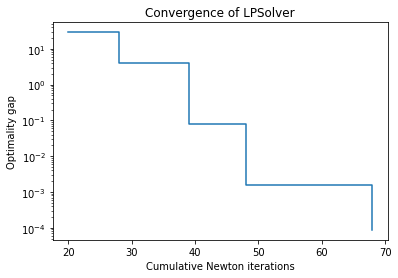

In [ ]:
ls_gpu.plot()

### Try out an inequality constrained problem (solver will run phase 1)

In [113]:
n = 100
m = 50
C = np.random.random((m,n))
C = np.where(np.random.binomial(1, 0.10, C.shape), C, 0)  # <- apply a random mask with 10% density  (A will be 90% sparse)
d = np.random.randint(low=1, high=30, size=C.shape[0])

c = np.random.randint(low=1, high=n, size=C.shape[1]) - n/2

In [117]:
# provide an x0 to force the solver to complete phase 1 solve

ls= LPSolver(c=c,
        A=None,
        b=None,
        C=C,
        d=d,
        use_gpu=False,
        upper_bound=None,
        lower_bound=0,
        suppress_print=False,
        x0=np.ones(len(c)))

Testing CVXPY
Starting slack of 3.3236


In [118]:
ls.solve() - ls.cvxpy_val

running phase 1 solver
Current slack: 3.3236071486774117
Current slack: 14920.057270879266
Current slack: 879.4430620613962
Current slack: 56.47086580226245
Current slack: 2.512246283739495
found a feasible point with slack -0.08995240435623797
proceeding to solve method
Objective value is now -6812.023410420645
Objective value is now -7474.494884895419
Objective value is now -7674.774784544737
Objective value is now -7701.009160957121
Objective value is now -7708.742188071684
Objective value is now -7710.234933778805
Objective value is now -7710.586629030179
Objective value is now -7710.7356961181595
Objective value is now -7710.774110252669
Objective value is now -7710.783229676763
Objective value is now -7710.783229676763


0.002667614298843546

### Run the same problem, but turn it into a QP by passing P to the identity matrix in QPSolver

In [133]:
qs= QPSolver(P=np.eye(len(c)), 
        q=c,
        A=A,
        b=b,
        C=None,
        d=None,
        use_gpu=False,
        upper_bound=None,
        lower_bound=0,
        suppress_print=False)

Testing CVXPY


In [134]:
qs.solve(track_loss=True) - qs.cvxpy_val

proceeding to solve method
Objective value is now 35.756912394351396
Objective value is now 31.822920404046332
Objective value is now 27.43504656641427
Objective value is now 26.927701135923318
Objective value is now 26.893665319764306
Objective value is now 26.891400796077697
Objective value is now 26.891251313275145
Objective value is now 26.891241461108322
Objective value is now 26.891240805503198
Objective value is now 26.8912407618021
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely unbounded)
Objective value is now 26.89124075986881
Reached max Newton steps during 11th centering step (t=10100000000.0)


-1.603339683242666e-09

<Axes: title={'center': 'Convergence of QPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

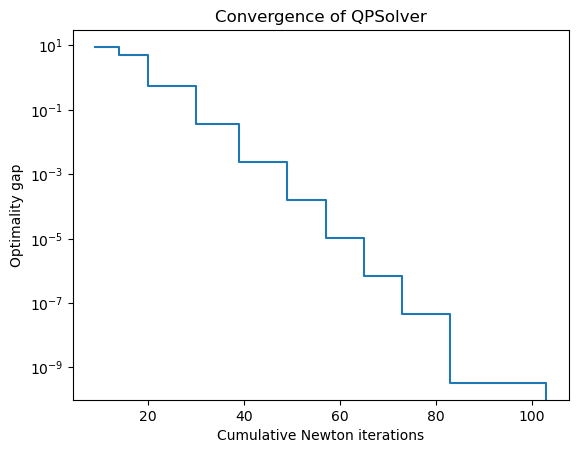

In [135]:
qs.plot()

## SOCP Solver

In [302]:
# Load in data from HW5

LAMBDA = 0.02
RHO = 0.4
T = 10
GROUPS = [
    [0],
    [1],
    [2],
    [3, 4, 5, 6, 7],
    [8, 9, 10, 11, 12, 13],
    [14, 15],
    [16],
    [17],
    [18],
]
FSTAR = 49.9649387126726

def get_weights(groups):

    group_sizes = list(map(len, groups))
    weights = np.sqrt(group_sizes)
    return weights

def load_data(X_train_path, y_train_path):
    X_train = np.loadtxt(X_train_path, delimiter=",")
    X_train = np.hstack([np.ones(X_train.shape[0])[:, np.newaxis], X_train])
    y_train = np.loadtxt(y_train_path, delimiter=",")
    return X_train, y_train

X, Y = load_data('example_data/X_train.csv', 'example_data/Y_train.csv')
w = get_weights(GROUPS)[1:]

Not able to run with GPU
Not able to run with GPU
Not able to run with GPU
Not able to run with GPU


In [305]:
w

array([1.        , 1.        , 2.23606798, 2.44948974, 1.41421356,
       1.        , 1.        , 1.        ])

In [306]:
1/(2*X.shape[0])*scs.x[:19].T@X.T@X@scs.x[:19]-scs.x[:19].T@X.T@Y/(X.shape[0]) +Y.T@Y/(2*X.shape[0]) +  LAMBDA*np.sum(scs.x[19:])

479.11148131663344

In [307]:
0.5*scs.x.T@P@scs.x + q@scs.x + Y.T@Y/(2*X.shape[0])

-1236.6814177828096

In [295]:
1/(2*X.shape[0])*np.linalg.norm(Y - X@scs.x[:19])**2 + LAMBDA*np.sum(scs.x[19:])

479.9821862710924

In [301]:
scs.cvxpy_sol

array([-71.80852358, -52.88938239,   4.56594336,  -7.44259605,
        30.28206978, -13.00054854,  -0.36427653, -13.00440701,
         1.10914369,   4.56273958,  10.20876703,   8.80275687,
       -13.64241804,  10.20566763,  16.94328341,  39.04783364,
        -6.32615151,  48.04709052, -23.02870887,  52.88938622,
         4.56594629,  36.20300751,  22.22673323,  42.56534342,
         6.326154  ,  48.0470941 ,  23.02871207])

In [303]:
# transform into format for SOCPSolver

P = np.block([[1/(X.shape[0])*X.T@X, np.zeros((19,8))], [np.zeros((8,19)), np.zeros((8,8))]])
q = np.hstack((-2*Y.T@X/(X.shape[0]), w*LAMBDA*np.ones(8)))
A, c = [], []
for i, g in enumerate(GROUPS[1:]):
    Ai = np.zeros((27,27))
    Ai[g,g] = 1
    ci = np.zeros(27)
    ci[19+i] = 1

    A.append(Ai)
    c.append(ci)

In [284]:
scs = SOCPSolver(P=P, 
        q=q,
        A=A,
        b=None,
        c=c,
        d=None,
        use_gpu=False,
        upper_bound=None,
        lower_bound=None,
        suppress_print=False)

Testing CVXPY
Starting slack of 1.5073


### Currently running into occasional bug where phase 1 solver converges to small positive number!

In [285]:
scs.solve() - scs.cvxpy_val

running phase 1 solver
Current slack: 1.5072789972687022
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely infeasible)
Reached max Newton steps during 0th centering step (t=0.01) of phase 1
Current slack: 704.0936367310511
Current slack: 53.36227029362586
Current slack: 3.557337684644466
Current slack: 0.237155850431077
Current slack: 0.01581039002858159
Current slack: 0.0010540260019045108
Current slack: 7.026840012603406e-05
Current slack: 4.684560007468937e-06
Current slack: 3.123039995645958e-07
Current slack: 2.082026570430639e-08
Current slack: 2.858793804062494e-09
Current slack: 2.8585795879575065e-09
Current slack: 2.8577165153840387e-09
Current slack: 2.8573716510905902e-09
Current slack: 2.8572337636328464e-09
Current slack: 2.8572337636328464e-09
Current slack: 2.8572337636328464e-09
Current slack: 2.8571786179650243e-09
Current slack: 2.857156561187939e-09
Current slack: 2.857147738715486e-09
Current slack: 2.8571442097646446e-09
Current slack: 2.85714

ValueError: Phase 1 Solver did not successfully find a feasible point!

### Try providing a feasible starting point to help the solver out

In [304]:
x0 = np.ones(27)
x0[19:]  = 10

scs = SOCPSolver(P=P, 
        q=q,
        A=A,
        b=None,
        c=c,
        d=None,
        use_gpu=False,
        upper_bound=None,
        lower_bound=None,
        suppress_print=False,
        x0=x0)

scs.solve() - scs.cvxpy_val

Testing CVXPY
Starting slack of -9.0
proceeding to solve method
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely infeasible)
Objective value is now -1575.2237809031376
Reached max Newton steps during 1th centering step (t=0.1)
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely infeasible)
Objective value is now -1706.6901920908592
Reached max Newton steps during 2th centering step (t=1.5)
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely infeasible)
Objective value is now -1713.9185511588882
Reached max Newton steps during 3th centering step (t=22.5)
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely infeasible)
Objective value is now -1714.283431273169
Reached max Newton steps during 4th centering step (t=337.5)
REACHED MAX ITERATIONS: Problem likely infeasible or unbounded (Likely infeasible)
Objective value is now -1714.3037015670943
Reached max Newton steps during 5th centering step (t=5062.5)
REACHE

-1.7225124793185387e-07

In [300]:
scs.x

array([-71.80872873, -52.88956599,   4.56596104,  -7.44353124,
        30.28238014, -13.00092867,  -0.36375075, -13.00478932,
         1.11002688,   4.56149057,  10.20928423,   8.7993196 ,
       -13.63683998,  10.20618791,  16.94387547,  39.04834866,
        -6.3262506 ,  48.04703206, -23.02877083,  52.88956601,
         4.56596106,  36.20372511,  22.22220832,  42.5660481 ,
         6.32625061,  48.04703207,  23.02877085])

In [288]:
# confirm that we get the same solution as in the homework

scs.value + Y.T@Y/(2*X.shape[0])

-1243.882190554701

## LassoSolver

(Our true winnner)

### Generate random problem data

Generate a sparse x so that it replicates a LASSO problem well. Generate multiple problem instances by generating a B matrix instead of just a vector

In [42]:
m = 500
n = 150
num_problems = 30
num_nonzero = 1000 # create a sparse x_true with this many nonzero entries
A = np.random.rand(m, n)
x_true = np.zeros((n, num_problems))
x_true[np.unravel_index(np.random.randint(0,n*num_problems, num_nonzero), (n, num_problems))] = np.random.uniform(0,50, num_nonzero)
reg = 0.05 + 0.01*np.random.randn(num_problems) # give each subproblem a slightly different regularization
B = A@x_true + np.random.randn(m, num_problems)

In [43]:
# create the LassoSolver object to solve all subproblems in parallel
# add the bias term and normalize A and then compare to CVXPY solver

ls = LassoSolver(
        A,
        B,
        reg=reg,
        rho=0.4,
        max_iters=1000,
        check_stop=10,
        add_bias=True,
        normalize_A=True,
        positive=False,
        compute_loss=True,
        adaptive_rho=False,
        eps_abs=1e-6,
        eps_rel=1e-4,
        use_gpu=False,
        num_chunks=0
    )


Testing CVXPY
CVXPY solving sample 1...Optimal value of 8.7319
CVXPY solving sample 2...Optimal value of 7.97
CVXPY solving sample 3...Optimal value of 11.7093
CVXPY solving sample 4...Optimal value of 9.7467
CVXPY solving sample 5...Optimal value of 7.1207
CVXPY solving sample 6...Optimal value of 15.4415
CVXPY solving sample 7...Optimal value of 11.7896
CVXPY solving sample 8...Optimal value of 12.9315
CVXPY solving sample 9...Optimal value of 9.6055
CVXPY solving sample 10...Optimal value of 14.0326
CVXPY solving sample 11...Optimal value of 15.1682
CVXPY solving sample 12...Optimal value of 13.0117
CVXPY solving sample 13...Optimal value of 7.4209
CVXPY solving sample 14...Optimal value of 16.821
CVXPY solving sample 15...Optimal value of 10.7675
CVXPY solving sample 16...Optimal value of 11.6879
CVXPY solving sample 17...Optimal value of 5.3332
CVXPY solving sample 18...Optimal value of 9.0115
CVXPY solving sample 19...Optimal value of 11.1071
CVXPY solving sample 20...Optimal val

In [44]:
X, solutions, gaps, iters = ls.solve()

In [45]:
# LassoSolver actually achieved lower objective values than CVXPY!
solutions - ls.cvxpy_vals

array([-0.0140556 , -0.012614  , -0.03042736, -0.00660579, -0.00967573,
       -0.03103403, -0.03130161, -0.03201509, -0.00926182, -0.02827502,
       -0.03045266, -0.02402663, -0.01187917, -0.03631419, -0.03596838,
       -0.03185047, -0.00631897, -0.01481339, -0.02384535, -0.01215494,
       -0.041747  , -0.03871213, -0.02708092, -0.00996747, -0.01312044,
       -0.01194128, -0.00608396, -0.03473075, -0.00369649, -0.04086586])

<Axes: title={'center': 'Convergence of LassoSolver'}, xlabel='iteration number', ylabel='Optimality gap'>

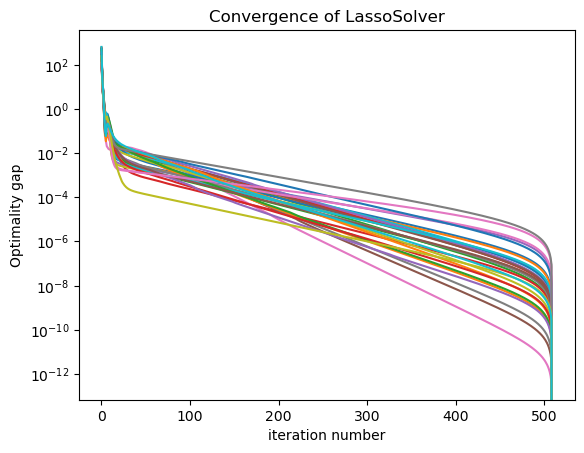

In [46]:
# note that, because LassoSolver achieved better objective values than CVXPY, the optimal value was considered the value at the end of the LassoSolver solve, which is why
# the optimality gap goes to negative infinity on the log plot
ls.plot()

### Benchmark against CVXPY
#### One good use case of solving multiple problems in parallel is being able to test several regularization strengths at the same time

In [97]:
# generate data
# have one vector for b (only solving one problem instance), but generate multiple values for regularization strength
# test 50 different regularization strengths logarithmically spaced from 10^-5 to 10^2

m = 400
n = 200
num_problems = 1
num_nonzero = 1000 # create a sparse x_true with this many nonzero entries
A = np.random.rand(m, n)
x_true = np.zeros((n, num_problems))
x_true[np.unravel_index(np.random.randint(0,n*num_problems, num_nonzero), (n, num_problems))] = np.random.uniform(0,50, num_nonzero)
reg = np.logspace(-5,2,50)
b = A@x_true + np.random.randn(m, num_problems)


In [98]:
# create the LassoSolver object to solve all subproblems in parallel
# turn off compute loss and lower epsilons a bit (resort to defauly -- we were already outperforming CVXPY anyways)
# add a bias term, but don't normalize A here

ls = LassoSolver(
        A,
        b,
        reg=reg,
        rho=0.4,
        max_iters=1000,
        check_stop=10,
        add_bias=True,
        normalize_A=False,
        positive=False,
        compute_loss=True,
        adaptive_rho=False,
        use_gpu=False,
        num_chunks=0,
        eps_rel=1e-3,
        check_cvxpy=False
    )

In [99]:
# time how long it takes to solve all the problems in CVXPY (we must solve sequentially)
from time import time
A = np.hstack((np.ones((m,1)), A))
start = time()
for r in reg:
    x = cp.Variable(n+1)
    obj = cp.Minimize(1/(2*m)*cp.norm2(A@x - b[:,0])**2 + r*cp.norm(x[1:], 1))
    prob = cp.Problem(obj, [])
    prob.solve(solver='CLARABEL')
print(time()-start)

22.367251873016357


In [100]:
%timeit ls.solve() # not bad for solving 50 different LASSO problems simultaneously -- and without GPU!
# we will get even better relative performance as problem size increases and GPU is implemented

1.08 s ± 260 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
# and just another sanity check: LassoSolver once again matches with CVXPY
ls.solve()
np.linalg.norm(ls.X[:,-1] - x.value)

0.004407873999298317